# Face Recognition Prototype: Detecting Unauthorized Image Use

This notebook demonstrates a simple prototype for a service that detects when a user's photo is uploaded to a platform without their consent. We will use the **DeepFace** library to find a specific person's face within a collection of other images.

## Step 1: Import Necessary Libraries 🛠️

First, we import the tools we need:
* `DeepFace`: The core AI library that contains pre-trained models for advanced face recognition.
* `cv2` (OpenCV) & `matplotlib`: Helper libraries for loading, processing, and displaying images.

In [ ]:
import cv2
import matplotlib.pyplot as plt

from deepface import DeepFace

## Step 2: Create a Helper Function for Display

This small function helps us display images easily throughout the notebook. It handles loading an image and showing it without axis labels for a cleaner look.

In [2]:
def display_image_with_plt(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load image. Check file path.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis("off") 
    plt.show()

## Step 3: Define the User's Photo (The Target) 🎯

Here, we specify the **target image**. This represents the reference photo of a registered user whose digital identity we want to protect. It's the face the system will be searching for. Let's display it to see who we're looking for.

In [3]:
target_image = "target\\paul_rudd_jennifer_aniston1.jpg"

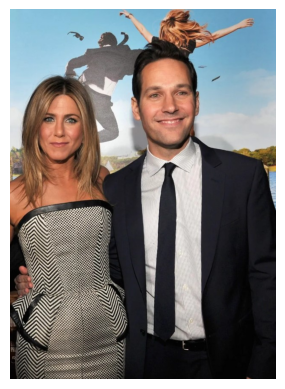

In [4]:
display_image_with_plt(target_image)

In [5]:
detected_people = DeepFace.find(
  img_path = target_image,
  db_path = "users\\",
)

25-05-27 01:21:02 - Searching target\paul_rudd_jennifer_aniston1.jpg in 37 length datastore
25-05-27 01:21:07 - find function duration 5.009913444519043 seconds


## Step 4: AI's Output

As you can see, the `results` variable is a list containing a pandas DataFrame. This isn't just a simple "match found" message; the AI provides rich, structured data for each match:

* **`identity`**: The path to the source image where the face was found.
* **`source_x`, `source_y`**: The coordinates of the top-left corner of the detected face's bounding box.
* **`source_w`, `source_h`**: The width and height of the bounding box around the detected face.
* **`distance`**: The similarity score. A lower value indicates a more confident match.

This detailed output, especially the coordinates, is crucial. It allows us to move beyond simply knowing a match exists to **visually proving it**, as we'll see in the next steps.

In [6]:
detected_people

[                                         identity  \
 0  users\jennifer_aniston\jennifer_aniston001.jpg   
 1  users\jennifer_aniston\jennifer_aniston002.jpg   
 2  users\jennifer_aniston\jennifer_aniston006.jpg   
 3  users\jennifer_aniston\jennifer_aniston005.jpg   
 4  users\jennifer_aniston\jennifer_aniston007.jpg   
 5  users\jennifer_aniston\jennifer_aniston004.jpg   
 
                                        hash  target_x  target_y  target_w  \
 0  e5c17a5d49c8b90da823bc0ae1a76915c0c3a848       365       364       827   
 1  c05225cbe34e663f502cad7e6a3d7169a5dd2674       171       147       348   
 2  fbd1bd2af770070522d35773815fe26df815e99a       252       175       231   
 3  e26db2cd74a5bef6abb4e13b4120105dffe3a64e       601       448       680   
 4  2a60cbfb65656bb1bc005a3f007bbf0d891f3e11       224       307       271   
 5  97678be7a2a69d8a31f923c121849cba231ecfa2       200        78       171   
 
    target_h  source_x  source_y  source_w  source_h  threshold  distanc

## Step 5: Visualization: Pinpointing the Matches

To make our demonstration more powerful, we need to do more than just list the files with matches. We need to show *exactly where* in the image the user's face appears. The next two functions are designed for this purpose.

### Helper Function 1: Organizing the Matches

The `get_unique_folders_with_coordinates_from_list` function processes the raw output from DeepFace. Its job is to group all the found faces by the image they appeared in. 

Why is this useful? Imagine our user's face appears twice in the same group photo. This function ensures we process that photo only once, but we get the coordinates for *both* faces. It organizes the data into a clean dictionary where each key is an image path and the value is a list of all face coordinates found in that image.

### Helper Function 2: Visualizing the Results

The `draw_faces_from_list` function takes this organized data and creates the final visual output. For each image that contains a match, it:
1.  Loads the image.
2.  Iterates through the list of coordinates for that image.
3.  Draws a green rectangle around each detected face using the coordinates provided by the AI.
4.  Displays the final image with the bounding boxes, offering clear, undeniable proof of the match.

In [7]:
def get_unique_folders_with_coordinates_from_list(dfs):
    all_results = []

    for df in dfs:
        df['folder_name'] = df['identity'].apply(lambda x: x.split("\\")[1] if "\\" in x else x.split("/")[1])
        unique_df = df.drop_duplicates(subset='folder_name')

        result = [
            {
                "identity": row["folder_name"],
                "source_x": row["source_x"],
                "source_y": row["source_y"],
                "source_w": row["source_w"],
                "source_h": row["source_h"],
            }
            for _, row in unique_df.iterrows()
        ]
        all_results.extend(result)

    return all_results


In [8]:
people = get_unique_folders_with_coordinates_from_list(detected_people)
people

[{'identity': 'jennifer_aniston',
  'source_x': 53,
  'source_y': 209,
  'source_w': 131,
  'source_h': 131},
 {'identity': 'paul_rudd',
  'source_x': 291,
  'source_y': 135,
  'source_w': 160,
  'source_h': 160}]

In [9]:
def format_identity(identity):
    return identity.replace('_', ' ').title()

def draw_faces_from_list(image_path, face_data):
    image = cv2.imread(image_path)
    if image is None:
        print("Не вдалося завантажити зображення. Перевірте шлях до файлу.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for face in face_data:
        x = face['source_x']
        y = face['source_y']
        w = face['source_w']
        h = face['source_h']
        identity = face['identity']

        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        font_scale = 1
        font_thickness = 2  
        text_x = x
        text_y = y - 10 if y - 10 > 10 else y + h + 20
        cv2.putText(image, format_identity(identity), (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


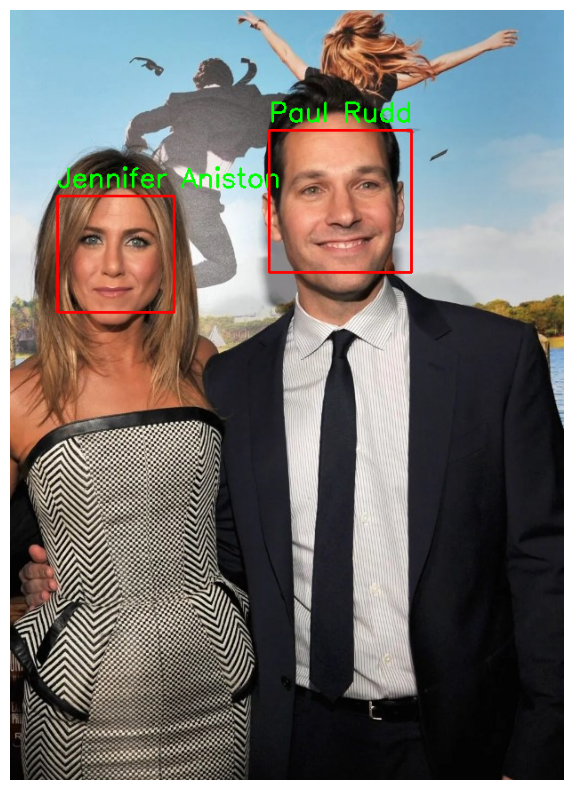

In [10]:
draw_faces_from_list("target\\paul_rudd_jennifer_aniston1.jpg", people)

## Step 6: Processing Results and Simulating Notifications 🔔

The raw data is useful, but we need to translate it into a user-friendly notification. This final function iterates through the results and, for each confirmed match, it:
1.  Prints a clear alert message.
2.  Provides the source of the detected photo.
3.  Shows the confidence score (distance).
4.  Displays the actual image where the user's face was found, providing visual proof.

In [11]:
def send_notification_stub(user_name):
    # In a real application, this would contain code to send an email, push notification, etc.
    # We extract the person's name from the path for a friendlier message.

    print(f"--> [NOTIFICATION STUB]: Sent notification to '{user_name}' that their face was found.")

In [12]:
def face_recognition(image_path):
    display_image_with_plt(image_path)
    detected_people = DeepFace.find(
        img_path = image_path,
        db_path = "users\\",

    )
    print("Detected people - ", len(detected_people))
    people = get_unique_folders_with_coordinates_from_list(detected_people)
    for person in people: send_notification_stub(person['identity'])
    draw_faces_from_list(image_path, people)


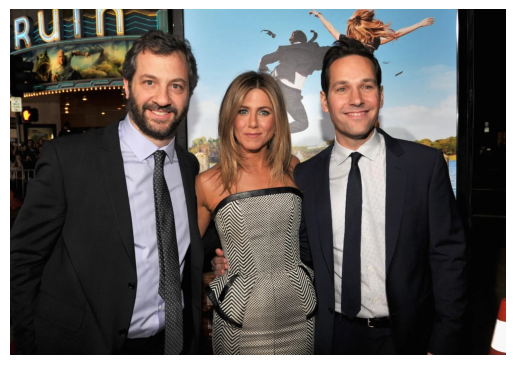

25-05-27 01:21:08 - Searching target\paul_rudd_jennifer_aniston2.jpg in 37 length datastore
25-05-27 01:21:11 - find function duration 3.3439810276031494 seconds
Detected people -  3
--> [NOTIFICATION STUB]: Sent notification to 'paul_rudd' that their face was found.
--> [NOTIFICATION STUB]: Sent notification to 'jennifer_aniston' that their face was found.


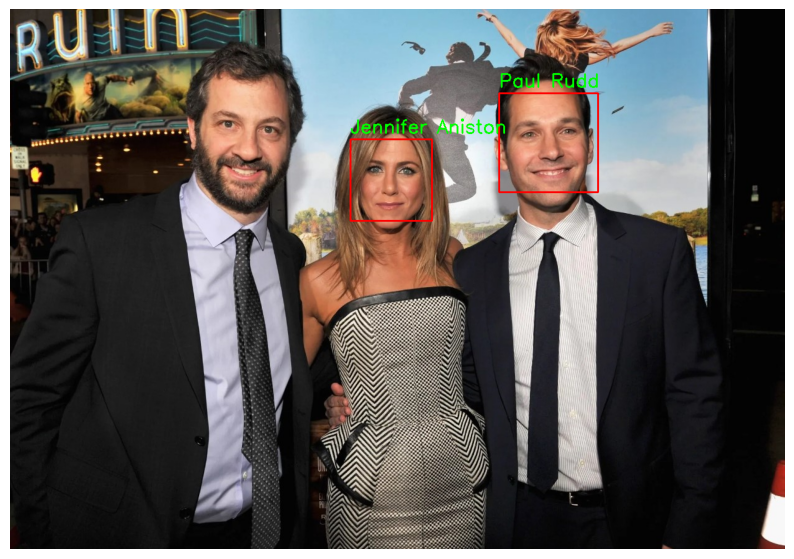

In [13]:
image_path = 'target\\paul_rudd_jennifer_aniston2.jpg'

face_recognition(image_path)